Matt Dula

Collaborators: Cory Hilton, Anthony Bennett, Anton Schlegel

# Flags & Interprocess Communication

It is common to use a variable as a "flag" that encodes information about a program's status. These flags can be shared between processes as a simple form of interprocess communication; however, increasing the amount of communication required also increases our parallel overhead. Sometimes, this increase in communication comes at a heavy cost and may not be worthwhile. 

This workbook serves two purposes:
* show you how to share objects between processes (we'll use these objects as flags)
* demonstrate how optimal parallel algorithms can sometimes be counterintuitive

The examples in this workbook are modified from [High Performance Python by Gorelick & Ozsvald](https://github.com/mynameisfiber/high_performance_python_2e/tree/master/09_multiprocessing).

## Verifying Prime Numbers

We will be reusing the `check_prime` function from workbooks 4 & 5:

In [1]:
import math

def check_prime(n):
    if n % 2 == 0:
        return False

    for i in range(3, int(math.sqrt(n)) + 1, 2):
        if n % i == 0:
            return False

    return True

Previously, we used this function to search a whole range of numbers for primes. In this example, we'll use it to verify whether or not individual very large numbers are prime. This will also adjust how we use `Pool.map`: instead of sharing a list of numbers that we need to search for primes, we'll share a list of *factors* for a single potentially prime number among multiple processes.

In `check_prime`, the line `for i in range(3, int(math.sqrt(n)) + 1, 2)` iterates all of the odd factors of `n`. We skip the even factors because if a number is divisible by an even factor it must also be divisible by two, and we check for this case first. But if we want to verify that a number like 100,109,100,129,100,151 is a prime number, we will still need to check 158,200,110 factors! 

When we previously used `check_prime`, the numbers we were searching only had around 5,000 factors each. That is, each process only had to handle *at most* around 5,000 iterations of the for-loop. For verifying whether or not these larger numbers are prime, it makes sense to share the roughly 158 million factors across multiple processes. In this way, the processes can collaboratively verify whether or not a given number is prime.

A function that verifies a large prime number by distributing these factors, called `parallel_check_prime`, is below:

In [2]:
import math
import multiprocessing
import functools

def chunk_factors(n, nchunks):
    """
    Returns a list of tuples, where each tuple is a pair of start and end values
    that a process should loop over.

    n: a number whose factors should be divided
    nchunks: the number of chunks into which to divide the factors
    """
    start = 3
    end = int(math.sqrt(n)) + 1

    # Start by making chunks that are as equal in length as possible
    # Any remainder will be added to the last chunks
    chunk_length = (end - start) / nchunks
    chunk_starts = list(range(start, end, int(chunk_length)))

    # keep the first chunk_start and 
    # make sure each subsequent value is odd
    kept_starts = [chunk_starts[0]]
    for lower in chunk_starts[1:]:
        if lower % 2 == 0:
            kept_starts.append(lower+1)
        else:
            kept_starts.append(lower)

    # perform some basic sanity checks
    if len(kept_starts) > nchunks: # whoops, too many somehow
        kept_starts.pop()

    assert len(kept_starts) == nchunks # protect ourselves from surprise bugs

    # construct our list of start & end tuples
    ranges = list(zip(kept_starts, kept_starts[1:])) + [(kept_starts[-1], end)]

    return ranges

def check_factors(range_tuple, n):
    """
    The argument range_tuple should be a length-two tuple whose
    first value specifies the start of a range and the second
    specifies the end of a range. If any numbers in this range
    are a factor of the argument n, return True. Otherwise,
    return False.
    """
   
    # the * shorthand automatically "unpacks" values in a tuple or list
    # the first value will be the first argument, 
    # the second value the second argument, etc
    for i in range(*range_tuple, 2):
        if n % i == 0:
            return False
    
    return True

def parallel_check_prime(n, nprocs=1):
    """
    Returns whether or not an integer n is prime. 
    Calculation is performed using nprocs different processes.
    """

    # Check the trivial case before launching process Pool
    if n % 2 == 0:
        return False

    # set up our list of tuple ranges to check
    ranges_to_check = chunk_factors(n, nprocs)

    # create a partial function fixing the number we want to check
    partial_check_factors = functools.partial(check_factors, n=n)

    with multiprocessing.Pool(processes=nprocs) as p:
        results = p.map(partial_check_factors, ranges_to_check)

    if False in results:
        return False

    return True


---
### Exercises

1. The function `check_prime`, which is given at the beginning of this section, has two main components: checking whether a given number is even, and checking whether it has any odd factors. The `parallel_check_prime` function in the code block above also has to have these components, but how are the implementations similar and/or different?

The `parallel_check_prime` function does explicitly check for evenness of the integer first, but then before checking for odd factors, it splits the factors to be checked into groupings to check which it then assigns the groups to different processes.

2. Look back at how you used `multiprocessing.Pool` with the original `check_prime` function back in workbook 4 & 5. How that implementation different from how we use `multiprocessing.Pool` with `parallel_check_prime`?

In workbooks 4 and 5, we checked many numbers for primeness using the check prime function across processes. Here, we are checking only one number, and dividing the factors to check against amongst processes.

3. Test `parallel_check_prime` on the values in the following dictionary. Use `nprocs` > 2 in order to make sure `parallel_check_prime` is implemented correctly in parallel.

**Hint:** you may wish to use a for-loop like `for label, number in test_nums.items():`


In [3]:
test_nums = {"cheaper non-prime": 112272535095295,
            "expensive non-prime 1": 100109100129100369,
            "expensive non-prime 2": 100109100129101027,
            "prime 1": 100109100129100151,
            "prime 2": 100109100129162907}

In [4]:
for label, number in test_nums.items():
    is_prime = parallel_check_prime(number, nprocs=16)
    print(f"{label} is prime: {is_prime}")

cheaper non-prime is prime: False
expensive non-prime 1 is prime: False
expensive non-prime 2 is prime: False
prime 1 is prime: True
prime 2 is prime: True


4. Time how long it takes to *individually* check each number in `test_nums` using the **original, serial** `check_prime`.

In [5]:
import time
import numpy as np

times_serial = np.empty(5)
for idx, (label, number) in enumerate(test_nums.items()):
    start = time.perf_counter()
    is_prime = check_prime(number)
    end = time.perf_counter()
    times_serial[idx] = end - start
    print(f"{label} is prime: {is_prime}, takes {round(end-start,8)} seconds to check")

cheaper non-prime is prime: False, takes 3.364e-05 seconds to check
expensive non-prime 1 is prime: False, takes 3.8329084 seconds to check
expensive non-prime 2 is prime: False, takes 6.60265412 seconds to check
prime 1 is prime: True, takes 12.61306147 seconds to check
prime 2 is prime: True, takes 13.09838258 seconds to check


5. Time how long it takes to *individually* check each number in `test_nums` when using **four processes** with `parallel_check_prime`.

In [6]:
times_parallel = np.empty(5)
for idx, (label, number) in enumerate(test_nums.items()):
    start = time.perf_counter()
    is_prime = parallel_check_prime(n=number, nprocs=4)
    end = time.perf_counter()
    times_parallel[idx] = end - start
    print(f"{label} is prime: {is_prime}, takes {round(end-start,8)} seconds to check")

cheaper non-prime is prime: False, takes 0.14996691 seconds to check
expensive non-prime 1 is prime: False, takes 3.31960135 seconds to check
expensive non-prime 2 is prime: False, takes 3.19195942 seconds to check
prime 1 is prime: True, takes 3.28154639 seconds to check
prime 2 is prime: True, takes 3.41981502 seconds to check


6. Using your timing measurements from above, what is the relative speedup from using `parallel_check_prime` for each number? Which values see a performance improvement? Which see a slowdown? Which see relatively little change? **Save these speedup calculations for later use.**

**Hint:** If `parallel_check_prime` was *slower* for some numbers, you still calculate speedup in the same way (old time divided by new time); the result will just be less than 1.

Speedups:\
cheaper non-prime:     x0.00009\
expensive non-prime 1: x1.15\
expensive non-prime 2: x1.13\
prime 1:               x3.85\
prime 2:               x3.97

7. One of our test numbers should take *significantly* longer when using `parallel_check_prime` instead of the original `check_prime`. Why do you think this is? Think about the costs of parallelization (i.e., parallel overhead) versus the amount of work each process has to do (i.e., the number of factors).

The cheaper non-prime takes significantly longer; I think this is because all the processes must completely run, and it is possible that one of the "chunks" contains no factors, so even if one chunk contains a factor, the total time is limited by the slowest chunk. Clearly, this cheap non-prime is divisible by 5 (so the serial prime finds a factor quickly), but the parallel prime creates a slow chunk that contains either no factors, or a factor that occurs late in the list of chunks.

---
## More Sophisticated Prime Verification - Exiting with Flags

When checking the factors of a number that is *not* prime, one or more processes is likely to exit the `check_factors` function *early*. That is, a process will `return False` before reaching the end of `range(*range_tuple, 2)`. What if we could signal all the other child processes that one of them has found a factor? Then, they could all stop checking any additional factors and avoid unnecessary work.

The `multiprocessing.Manager()` object lets us share Python objects between processes. These can be "lower-level" objects like integers and floating point numbers, or more complex objects like lists and dictionaries. We'll use `Manager.Value` to implement a simple flag that indicates whether or not a process has found a factor. Every process will periodically check the value of this flag to see whether or not it should continue its search.

The same `Manager.Value` object (which we're calling `factor_found`) has to be available on all of the processes. We'll initialize it on the parent and use the `global` keyword to ensure that the variable `factor_found` is defined everywhere. The various data that the `Manager` can share (`Value` and `Array`, which we'll see next week) automatically has a "lock" feature enabled to ensure safe collaboration between processes. As with the file writing locks, this safe collaboration comes at the cost of increased overhead.

In [7]:
def check_factors_flagged(range_tuple, n, check_interval=1000):
    """
    The argument range_tuple should be a length-two tuple whose
    first value specifies the start of a range and the second
    specifies the end of a range. If any numbers in this range
    are a factor of the argument n, return True. Otherwise,
    return False.

    The check_interval argument controls how frequently a process
    checks the "factor_found" flag. A smaller interval means more
    interprocess communication, but may also mean a more advantageous
    exit.
    """
    
    check = check_interval

    # the * shorthand automatically "unpacks" values in a tuple or list
    # the first value will be the first argument, 
    # the second value the second argument, etc
    for i in range(*range_tuple, 2):

        check -= 1
        if not check: # countdown reached 0
            if factor_found.value: # did someone set the flag to True?
                return False
            check = check_interval # reset "timer"

        if n % i == 0:
            factor_found.value = True # set flag ourselves
            return False
            
    return True

def parallel_check_prime_flagged(n, nprocs=1, flag_interval=1000):
    """
    Returns whether or not an integer n is prime. 
    Calculation is performed using nprocs different processes.

    A flag is used to determine whether or not another process
    has found a factor. This flag is checked every flag_interval times.
    """

    # Check the trivial case before launching process Pool
    if n % 2 == 0:
        return False
    
    # set up the Value object that we'll use as our flag
    manager = multiprocessing.Manager()
    global factor_found # set the scope of factor_found
    factor_found = manager.Value(bool, False)

    # set up our list of tuple ranges to check
    ranges_to_check = chunk_factors(n, nprocs)

    # create a partial function fixing the number we want to check
    partial_check_factors = functools.partial(check_factors_flagged,
                                              n=n,
                                              check_interval=flag_interval)

    # pass the Value object created above to each process
    # using the init_flag() function to "rename" it as factor_found
    # note that initargs has to be a list
    with multiprocessing.Pool(processes=nprocs) as p:
        results = p.map(partial_check_factors, ranges_to_check)

    if False in results:
        return False

    return True

---
### Exercises

1. Comparing the code above to that in the first section, list the changes that had to be made to in order to use a flag between processes. Summarize what the changes accomplish rather than listing individual lines; for example, "added an initializer function to set up each flag on each process." Note that `chunk_factors` didn't need to be changed in order to add the flag.

In the outermost function, added the instantiation of a global flag to be shared among processes. In the inner function that actually checks factors, added a countdown to determine how often to check whether the global variable has been set to true.

2. Using `parallel_check_prime_flagged` with **four processes**, time how long it takes to check each number in `test_nums`. Then, find the speedup compared to the original *serial* `check_prime`.

In [8]:
times_parallel_flagged = np.empty(5)
for idx, (label, number) in enumerate(test_nums.items()):
    start = time.perf_counter()
    is_prime = parallel_check_prime_flagged(n=number, nprocs=4)
    end = time.perf_counter()
    times_parallel_flagged[idx] = end - start
    print(f"{label} is prime: {is_prime}, takes {round(end-start,8)} seconds to check")

cheaper non-prime is prime: False, takes 0.14847752 seconds to check
expensive non-prime 1 is prime: False, takes 1.56421633 seconds to check
expensive non-prime 2 is prime: False, takes 1.30247601 seconds to check
prime 1 is prime: True, takes 7.55217744 seconds to check
prime 2 is prime: True, takes 7.57095168 seconds to check


3. Plot your speedups for `parallel_check_prime` and `parallel_check_prime_flagged` as a grouped bar graph. This is most easily done if you put your speedup data into a Pandas DataFrame (e.g. one named `df`). Each column will be one of the functions, while the row indexes will be the categories from `test_num`. You can then plot with `df.plot.bar(logy=True)`.

    How does the speedup of `parallel_check_prime_flagged` compare to the speedup of `parallel_check_prime`?

<Axes: title={'center': 'Speedup vs. Serial'}>

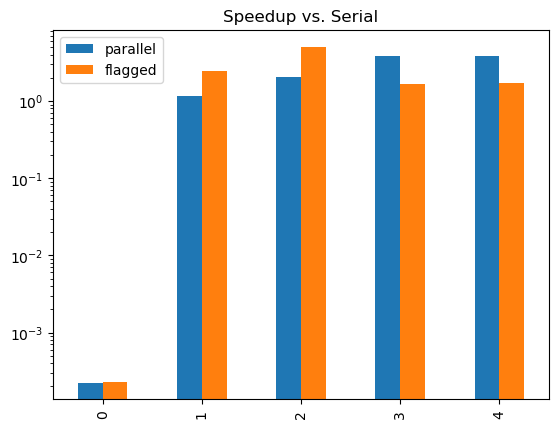

In [9]:
import pandas as pd

times_array = times_serial / np.array([times_parallel,times_parallel_flagged])
df = pd.DataFrame(times_array.T, columns=['parallel','flagged'])

df.plot.bar(logy=True,title='Speedup vs. Serial')

Flagged has better performance for all 3 cases of non-primes, while the regular parallel has better performance for the case of both prime numbers.

4. You should see that the time it takes to verify the *actual* prime numbers is now longer (i.e. the speedup is lesser). Why is that? Think about the purpose of the flag we implemented, and how it applies to prime numbers.

This is because with prime numbers, all the numbers are actually checked, so the overhead of checking the flag actually just introduces more work, and the work of checking all factors still has to be done (although in general, we don't actually know in advance if a number is prime or not).

5. Try doubling the number of iterations between flag checks from 1000 to 2000 using the `flag_interval` and re-measure the speedup for each individual number. Does this make a significant difference? What do you think has a bigger impact on performance, the frequency with which we check the flag or the mere act of checking a flag at all?

cheaper non-prime is prime: False, takes 0.07022937 seconds to check
expensive non-prime 1 is prime: False, takes 1.44269135 seconds to check
expensive non-prime 2 is prime: False, takes 1.31513774 seconds to check
prime 1 is prime: True, takes 6.84932216 seconds to check
prime 2 is prime: True, takes 6.71569132 seconds to check


<Axes: title={'center': 'Speedup vs. Serial'}>

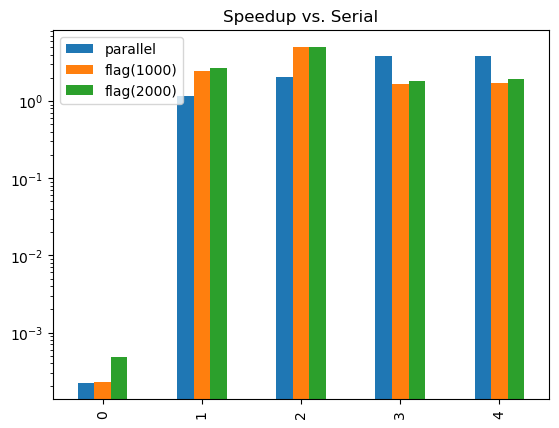

In [10]:
times_parallel_flagged2 = np.empty(5)
for idx, (label, number) in enumerate(test_nums.items()):
    start = time.perf_counter()
    is_prime = parallel_check_prime_flagged(n=number, nprocs=4, flag_interval=2000)
    end = time.perf_counter()
    times_parallel_flagged2[idx] = end - start
    print(f"{label} is prime: {is_prime}, takes {round(end-start,8)} seconds to check")

times_array = times_serial / np.array([times_parallel,times_parallel_flagged,times_parallel_flagged2])
df = pd.DataFrame(times_array.T, columns=['parallel','flag(1000)','flag(2000)'])

df.plot.bar(logy=True,title='Speedup vs. Serial')

From the bar graph, the difference between `parallel` and `parallel_flagged` is much greater than the difference between either instance of the `parallel_flagged` variations, so I believe that the act of checking a flag at all is what introduces the main speedup.

## The Goldilocks Compromise

Our original parallel prime verification function, `parallel_check_prime`, has very poor performance when checking smaller non-prime numbers. We used a flag to try to reduce unnecessary extra work by telling processes to stop if another process had already found a factor. Unfortunately, this flag introduced extra communication that make it inefficient to verify numbers that are actually prime.

An ideal prime verification method would have reasonable performance for all of the cases we are testing. It should efficiently weed out non-prime numbers both big and small *and* efficiently verify large prime numbers with many factors. Because we want a general-purpose method that can process prime numbers of different sizes, we'll have to make a compromise when it comes to performance.

Using a pool of processes is beneficial for checking large numbers but incurs a penalty for small numbers. One straightforward design choice is to therefore check the most common set of factors *in serial* before creating the process pool. We'll call this version `parallel_check_prime_compromise` and it requires us to modify our `chunk_factors` function:

In [11]:
def chunk_factors_flexible(n, nchunks, start=3):
    """
    Returns a list of tuples, where each tuple is a pair of start and end values
    that a process should loop over.

    n: a number whose factors should be divided
    nchunks: the number of chunks into which to divide the factors
    """
    
    end = int(math.sqrt(n)) + 1

    # Start by making chunks that are as equal in length as possible
    # Any remainder will be added to the last chunks
    chunk_length = (end - start) / nchunks
    chunk_starts = list(range(start, end, int(chunk_length)))

    # keep the first chunk_start and 
    # make sure each subsequent value is odd
    kept_starts = [chunk_starts[0]]
    for lower in chunk_starts[1:]:
        if lower % 2 == 0:
            kept_starts.append(lower+1)
        else:
            kept_starts.append(lower)

    # perform some basic sanity checks
    if len(kept_starts) > nchunks: # whoops, too many somehow
        kept_starts.pop()

    assert len(kept_starts) == nchunks # protect ourselves from surprise bugs

    # construct our list of start & end tuples
    ranges = list(zip(kept_starts, kept_starts[1:])) + [(kept_starts[-1], end)]

    return ranges

def parallel_check_prime_compromise(n, nprocs=1, precheck_stop=20):
    """
    Returns whether or not an integer n is prime. 
    Calculation is performed using nprocs different processes
    *if* the candidate number n fails a serial "pre-check."
    This pre-check tests factors up to and including precheck_stop.
    """

    # Check the trivial case before launching process Pool
    if n % 2 == 0:
        return False

    # Also check common, small factors before the process Pool.
    # Include "precheck_stop" in the range of factors we test.
    for i in range(3, precheck_stop+1, 2):
        if n % i == 0:
            return False

    # set up our list of tuple ranges to check
    ranges_to_check = chunk_factors_flexible(n, nprocs, precheck_stop+1)

    # create a partial function fixing the number we want to check
    partial_check_factors = functools.partial(check_factors, n=n)

    with multiprocessing.Pool(processes=nprocs) as p:
        results = p.map(partial_check_factors, ranges_to_check)

    if False in results:
        return False

    return True

You'll notice that we have removed the `Manager.Value` flag implementation in this version. This "compromise" approach will still have processes doing "unnecessary work"; that is, a process won't stop checking factors just because another process discovered that the number is not prime. Avoiding this unnecessary work requires flags, but the flags themselves introduce a performance penalty.
In the exercises below, we'll see if this reduced communication (i.e. not synchronizing flags) is more beneficial to our performance than avoiding unnecessary work.

---
### Exercises

1. How do the functions above (`parallel_check_prime_compromise` and `chunk_factors_flexible`) compare to the versions in the first section (`parallel_check_prime` and `chunk_factors`)? What do they do that is similar? How is their behavior different? What modifications were implemented?

They both begin in the `parallel_check_prime*` with a check for even-ness, and they both construct smaller sets of possible factors to check for divisibility in `chunk_factors*`. However, the `parallel_check_prime_compromise` function continues to check even more small factors above 2, given by a user input (`precheck_stop`). Accordingly, the `chunk_factors_flexible` does not guarantee to start considering factors at 3, but begins at the value past the input value of the `precheck_stop` argument.

2. Is `parallel_check_prime_compromise` more similar in behavior to `parallel_check_prime` or `parallel_check_prime_flagged`?

I consider it more similar to `parallel_check_prime`, because implementing the pre-check stop is essentially equivalent to checking if a number is even first, just using numbers above two. There is not interruption in checking factors, it simply checks small factors first.

3. Using `check_prime_compromise` with four processes, time how long it takes to check each number in `test_nums`. Then, find the speedup compared to the original serial `check_prime`.

cheaper non-prime is prime: False, takes 4.3e-06 seconds to check
expensive non-prime 1 is prime: False, takes 3.42260039 seconds to check
expensive non-prime 2 is prime: False, takes 3.39327997 seconds to check
prime 1 is prime: True, takes 3.59251361 seconds to check
prime 2 is prime: True, takes 3.59234731 seconds to check


<Axes: title={'center': 'Speedup vs. Serial'}>

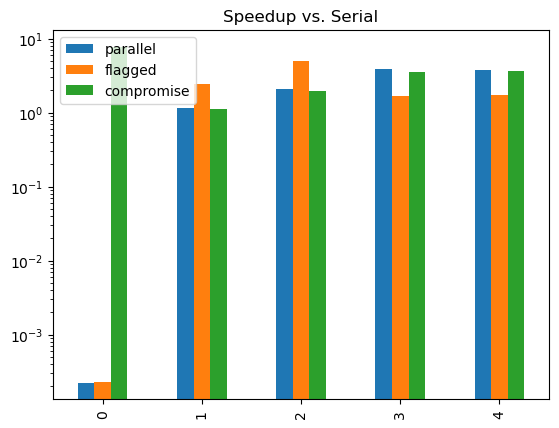

In [12]:
times_compromise = np.empty(5)
for idx, (label, number) in enumerate(test_nums.items()):
    start = time.perf_counter()
    is_prime = parallel_check_prime_compromise(n=number, nprocs=4)
    end = time.perf_counter()
    times_compromise[idx] = end - start
    print(f"{label} is prime: {is_prime}, takes {round(end-start,8)} seconds to check")

speedup_array = times_serial / np.array([times_parallel,times_parallel_flagged,times_compromise])
df = pd.DataFrame(speedup_array.T, columns=['parallel','flagged','compromise'])

df.plot.bar(logy=True,title='Speedup vs. Serial')

4. Recreate the bar graph from before, but this time plot the speedup of `parallel_check_prime`, `parallel_check_prime_flagged`, and `parallel_check_prime_compromise`.

    Is `parallel_check_prime_compromise` actually a good compromise?

See above for the speedup bar graph. I consider that `parallel_check_prime_compromise` is a good compromise, because it achieves speedup of greater than 1 in the case of the cheap primes (which is quite common, given that 1/N of all positive integers are divisible by N, for any positive integer N). We get approximately the same best speedup of parallel in the case of primes, since we do not add flagging work. The only case where we are hurt is in the case of expensive primes, but there is still a speedup corresponding to how small the first factor is.

5. When we learned about strong scaling, we learned to think of our programs as having serial and parallel components. These components can be thought of as fractions that sum to one. Compared to the original `parallel_check_prime`, did `parallel_check_prime_compromise` increase or decrease the serial fraction?

`parallel_check_prime_compromise` increases the serial fraction, because more work is done prior to splitting the possible factors into parallel chunks (ie, code is added that does work outside of the `multiprocessing.Pool()` section.

6. Based on your previous answer, would you agree or disagree with the following statement: "The best parallel performance always come from making the serial component of a program as small as possible."

I would not agree with that statement. The real goal is not to achieve 100% parallelization, but rather to minimize time. As we have just shown, it is possible for a bit of serialized code to massively decrease (or even eliminate) the actual total workload in a way that parallelization sometimes cannot.

---
## Takeaways

Hopefully the motivation behind `parallel_prime_check_flagged` initially seemed like an intuitive, straightforward way to improve the performance of our code; after all, reducing the amount of work there is to do should make our code run faster, right?

As you've seen in this workbook, though, that line of thinking doesn't always apply to parallel programs. What's often more important is reducing the amount of parallel overhead. The kind of overhead that we have the most control over is interprocess communication. Other kinds, like launching and shutting down multiple processes, can't be reduced much further. Reducing communication will usually lead to better gains in the long run, even if it means your processes do redundant or unnecessary work. Though of course, you should always use performance measurements to check!

The `parallel_prime_check_compromise` uses a "serial pre-check" strategy to help avoid costly overhead (both from communication and from managing multiple processes). This kind of strategy is common, and you may be able to apply it to your own research.